# Proyecto 1

**Andres Chaparro - 202111146** 


In [101]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carga de datos (csv)
Se cargan la base de datos (CSV) para trabajar con estos

In [117]:
direccionTrain = 'apartments_for_rent_classified_10K.csv'
data_original = pd.read_csv(direccionTrain, sep=';', encoding='latin1')
data_original.shape

(10000, 22)

# 2. Entendimientos de los datos

### 2.1 Datos Nulos

Como se puede observar El análisis muestra que varias columnas tienen valores nulos, destacando `amenities`, `pets_allowed` y `address` con una cantidad significativa. Otras columnas tienen pocos valores faltantes, mientras que la mayoría está completa, lo que facilita el análisis general.

In [119]:
features = data_original.columns
data_original[features].isnull().sum() 

id                  0
category            0
title               0
body                0
amenities        3549
bathrooms          34
bedrooms            7
currency            0
fee                 0
has_photo           0
pets_allowed     4163
price               0
price_display       0
price_type          0
square_feet         0
address          3327
cityname           77
state              77
latitude           10
longitude          10
source              0
time                0
dtype: int64

El análisis porcentual muestra que las columnas `amenities`, `pets_allowed` y `address` tienen los mayores porcentajes de valores nulos (35.49 %, 41.63 % y 33.27 %, respectivamente). Las demás columnas tienen porcentajes insignificantes de datos faltantes, facilitando su uso para análisis más detallados.

In [120]:
data_original[features].isnull().sum() /data_original.shape[0] * 100

id                0.00
category          0.00
title             0.00
body              0.00
amenities        35.49
bathrooms         0.34
bedrooms          0.07
currency          0.00
fee               0.00
has_photo         0.00
pets_allowed     41.63
price             0.00
price_display     0.00
price_type        0.00
square_feet       0.00
address          33.27
cityname          0.77
state             0.77
latitude          0.10
longitude         0.10
source            0.00
time              0.00
dtype: float64

### 2.2 Graficas de disperción de las variables continuas

Como se puede observar en las graficas de disperción las variables square_feed muestra una relacion algo incremental pero con aleatoriedad, por otro lado, latitud y longitud muestran tambien una disperción aleatoria. Por otro lado las variables id y time muestran una dispercion similar, lo que puede ocasionar correlacion entre estos mas adelante, esto puede suceder si el id se creo con respecto al tiempo de creación, lo cual suele ser normal.

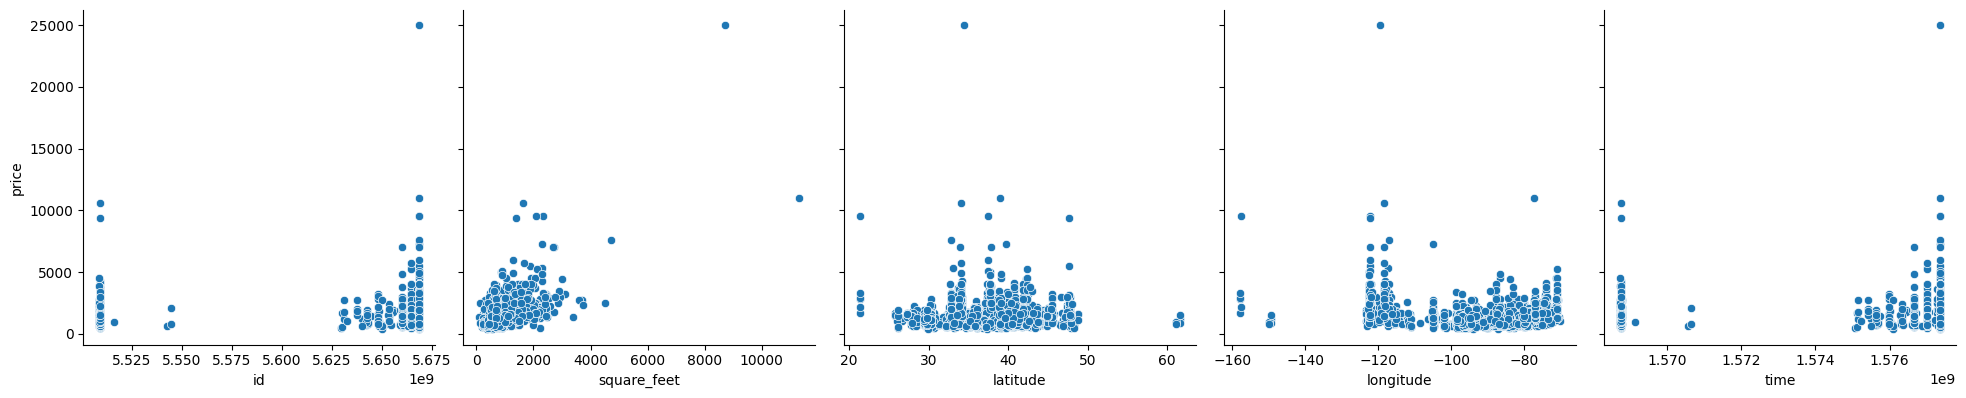

In [121]:
numerical_columns = data_original.select_dtypes(include=[np.number]).columns
numerical_columns = numerical_columns.drop(['bathrooms', 'bedrooms', 'price'])
sns.pairplot(data_original.sample(frac=0.2), height=4, y_vars="price", x_vars=numerical_columns, kind="scatter")

### 2.3 Histogramas para variables continuas

Como se puede observar en los histogramas de id y time tienen una distribucion similar con valores en extremos y no acumulados en una media. Por otro lado, el tamaño del piso muestra una distribucion acumulada en una media de 945, sin embargo, tiene valores extremos que pueden alterar su grafica ya que tiene un valor maximo de 40000 que puede ser un outlier. Por ultimo, la distribución de latitud y longitud muestran una distribucion aleatorias sin rasgos fuera de lo común.

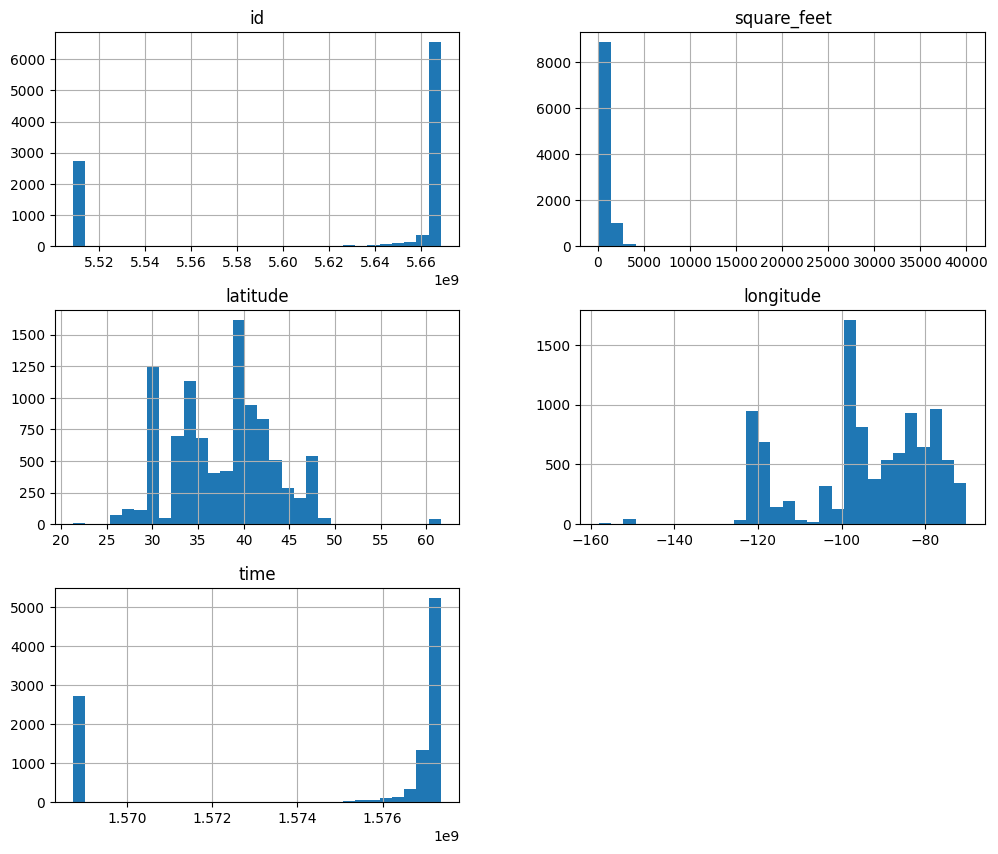

In [122]:
data_original[numerical_columns].hist(figsize=(12, 10), bins=30)
plt.show()

In [123]:
print(data_original[numerical_columns].describe())

                 id   square_feet     latitude    longitude          time
count  1.000000e+04  10000.000000  9990.000000  9990.000000  1.000000e+04
mean   5.623396e+09    945.810500    37.695162   -94.652247  1.574891e+09
std    7.021025e+07    655.755736     5.495851    15.759805  3.762395e+06
min    5.508654e+09    101.000000    21.315500  -158.022100  1.568744e+09
25%    5.509248e+09    649.000000    33.679850  -101.301700  1.568781e+09
50%    5.668610e+09    802.000000    38.809800   -93.651600  1.577358e+09
75%    5.668626e+09   1100.000000    41.349800   -82.209975  1.577359e+09
max    5.668663e+09  40000.000000    61.594000   -70.191600  1.577362e+09


### 2.3 BoxPlot para variables categoricas

Para graficar las variables categoricas primero se filtran los datos para obtener estas variables contando la cantidad de valores unicos por variable y filtrandola por maximo 52 valores unicos que es el mayor caso que es el del estado donde se encuentra el apartamento

In [124]:
category_counts = data_original.nunique()
categorical_columns_filtered = category_counts[category_counts < 52].index
categorical_columns_filtered

Index(['category', 'bathrooms', 'bedrooms', 'currency', 'fee', 'has_photo',
       'pets_allowed', 'price_type', 'state', 'source'],
      dtype='object')

Como se puede Observar en los BoxPLot hay algunas variables que tienen una sola categoria, por lo que estas variables son obsoletas para nuestro modelo. Por otro lado, las otras variables tienen una distribución mas aleatoria que no muestran un patron claro, sin embargo, la cantidad de baños y cuartos si muestran una relacion creciente con respecto al precio.

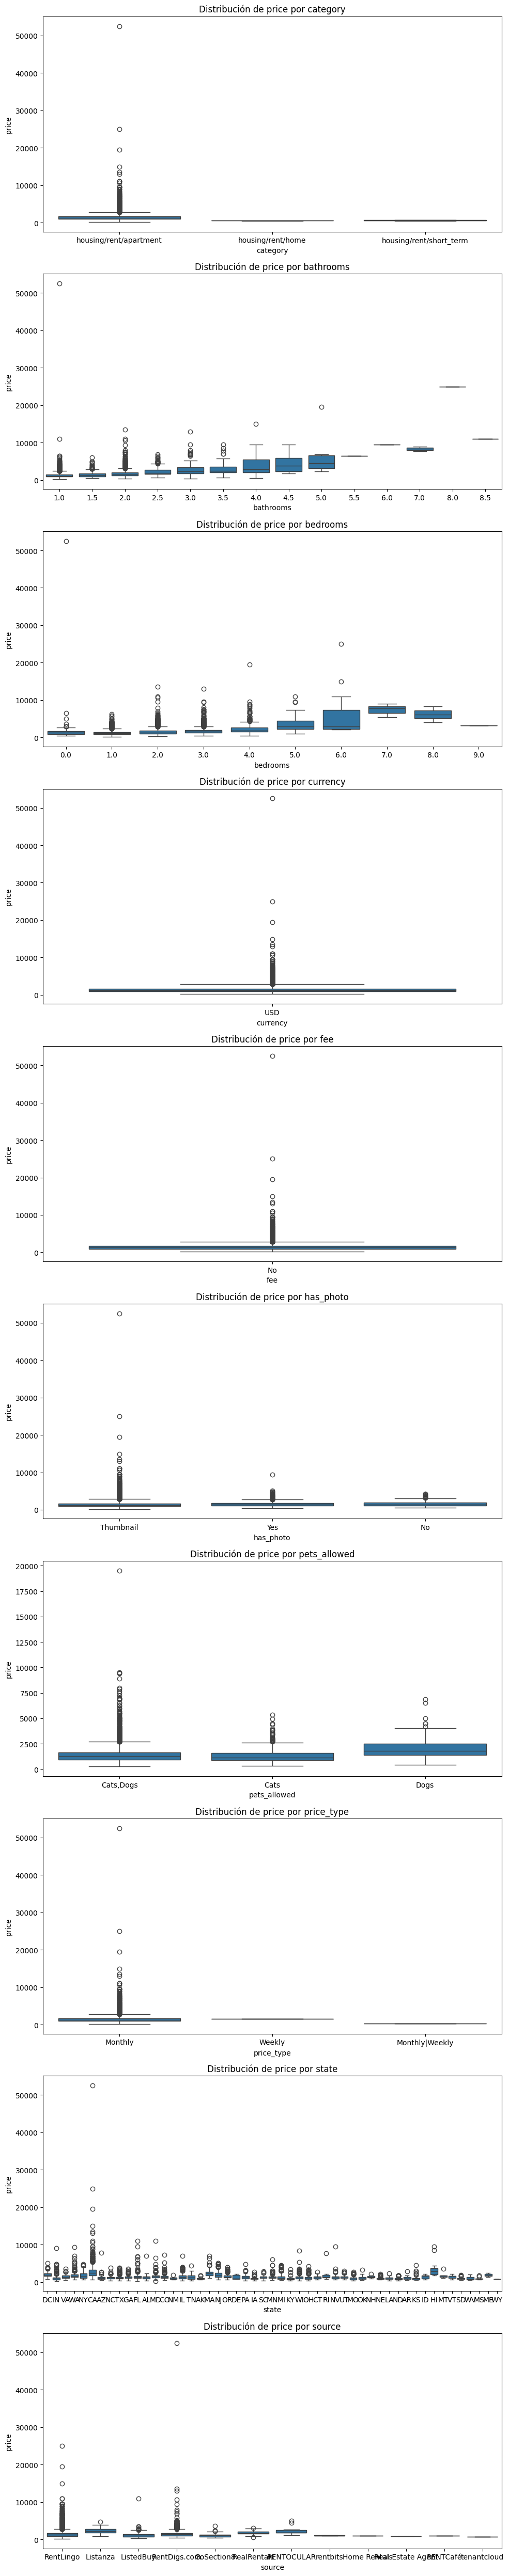

In [109]:
fig, axes = plt.subplots(nrows=len(categorical_columns_filtered), ncols=1, figsize=(10, 5 * len(categorical_columns_filtered)))

for ax, feature in zip(axes, categorical_columns_filtered):
    sns.boxplot(data=data_original, x=feature, y="price", ax=ax)
    ax.set_title(f"Distribución de price por {feature}")

plt.tight_layout()
plt.show()

# 3. Limpieza de datos

### 3.1 Selección de variables por valores unicos

Para la selección de variables, se eliminarán aquellas que son irrelevantes para los modelos, como las que contienen un único valor constante. En este caso, se retirarán las variables *currency* y *fee*, ya que no aportan información útil al análisis.

In [125]:
# Eliminar columnas con un solo valor único como es currency y fee
columns_to_drop = data_original.nunique()[data_original.nunique() == 1].index
data_filtered_1 = data_original.drop(columns=columns_to_drop)
data_filtered_1.shape

(10000, 20)

### 3.2 Selección de variables por correlación

Dado que las columnas `id` y `time` tienen una correlación perfecta (1), se decidió eliminar ambas variables. Una correlación de 1 indica que ambas contienen exactamente la misma información, lo que las hace redundantes. Además, el significado de estas variables no aporta valor al modelo: `id` es únicamente un identificador sin relevancia predictiva, y `time`, aunque representa cuándo se creó el anuncio, no es útil para estimar el precio de los apartamentos. Por lo tanto, se eliminan ambas para evitar redundancias y optimizar el conjunto de datos.

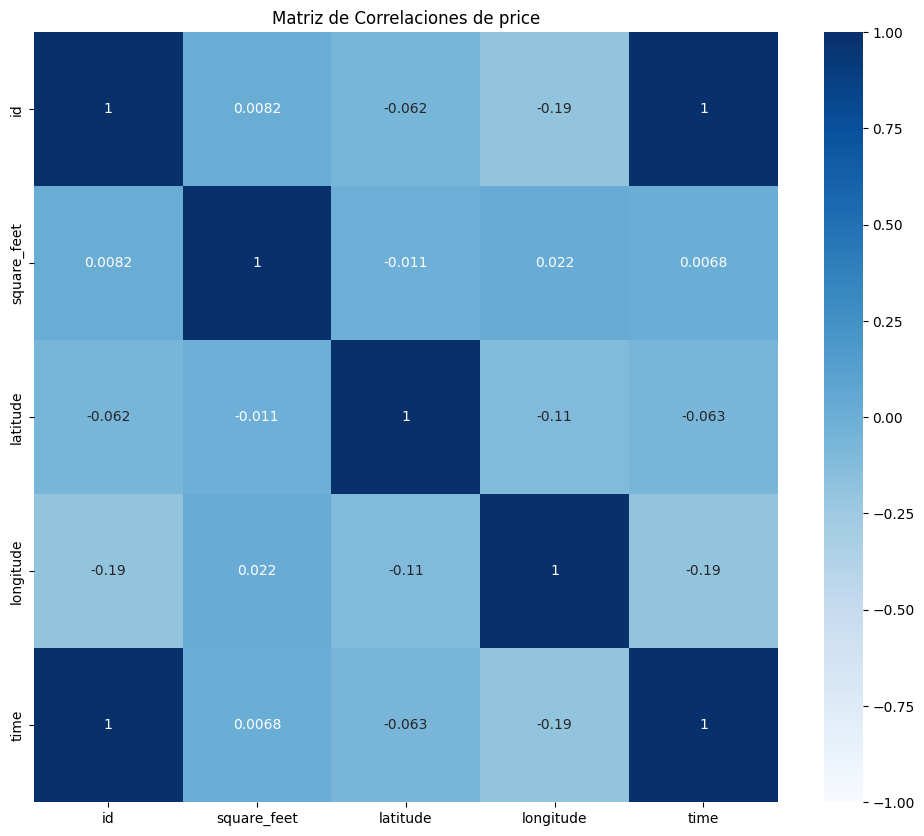

In [126]:
numerical_columns = data_original.select_dtypes(include=[np.number]).columns
numerical_columns = numerical_columns.drop(['bathrooms', 'bedrooms', 'price'])
correlation_matrix = pd.DataFrame(data_original, columns=numerical_columns).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="Blues", vmin=-1, vmax=1, annot=True)
plt.title("Matriz de Correlaciones de price")
plt.show()

In [127]:
data_filtered_2 = data_filtered_1.drop(columns=['id', 'time'])
data_filtered_2.shape

(10000, 18)

### 3.3 Selección de variables por modelo de negocio

Se decidió eliminar la columna `price_display`, ya que contiene la misma información que la columna `price`, la cual es nuestra variable objetivo en el modelo. Mantener ambas variables sería redundante y no aportaría valor adicional al análisis. Además, la presencia de `price_display` podría introducir ruido en el modelo y afectar su desempeño, ya que el modelo estaría procesando información duplicada. Por lo tanto, se prioriza conservar únicamente `price` como la representación del valor objetivo.

In [128]:
data_filtered_3 = data_filtered_2.drop(columns=['price_display'])
data_filtered_3.shape

(10000, 17)

Se decidió procesar la columna `price_type` para unificar los valores de la variable `price` en términos mensuales, ya que la mayoría de los datos ya están expresados en esta unidad. Para los registros donde `price_type` sean valores semanales, se multiplicará el `price` por 4 para convertirlos a valores mensuales. Por otro lado, se eliminarán los registros donde `price_type` tenga el valor `Monthly|Weekly`, ya que este no especifica si el precio corresponde a un mes o una semana, lo que podría introducir errores en el análisis.

In [129]:
data_filtered_4 = data_filtered_3.copy()
data_filtered_4.loc[data_filtered_4['price_type'] == 'Weekly', 'price'] *= 4

# Eliminar los registros con price_type 'Monthly|Weekly'
data_filtered_4 = data_filtered_4[data_filtered_4['price_type'] != 'Monthly|Weekly']

# Eliminar la columna price_type, ya que ya no es necesaria
data_filtered_4.drop(columns=['price_type'], inplace=True)

data_filtered_4.shape


(9999, 16)

### 3.3 Limpieza de datos por datos nulos

Para la limpieza de los datos, se decidió imputar los valores nulos de las variables **latitude** y **longitude** con la mediana, dado que la cantidad de datos faltantes es mínima y esta estrategia preserva la distribución central de las coordenadas. En el caso de **bathrooms** y **bedrooms**, se optó por completar los valores nulos con el promedio, ya que son variables numéricas. Aunque inicialmente parecen ser categóricas, al representar cantidades discretas, se pueden tratar como variables continuas y luego redondear el promedio al entero más cercano para mantener consistencia en su interpretación. Esto asegura que los datos estén completos sin introducir sesgos significativos en el análisis. Para las demas variables se hara el analisis despues.

In [130]:
data_filtered_4.isnull().sum() /data_filtered_4.shape[0] * 100
variables_con_nulos = data_filtered_4.columns[data_filtered_4.isnull().sum() > 0]
nulos_df = pd.DataFrame({
    'Cantidad de Nulos': data_filtered_4.isnull().sum()[variables_con_nulos],
    'Porcentaje de Nulos': data_filtered_4.isnull().sum()[variables_con_nulos] / data_filtered_4.shape[0] * 100,
    'Tipo de Dato': data_filtered_4.dtypes[variables_con_nulos]
})
nulos_df

,Cantidad de Nulos,Porcentaje de Nulos,Tipo de Dato
amenities,3549,35.493549,object
bathrooms,33,0.330033,float64
bedrooms,6,0.060006,float64
pets_allowed,4163,41.634163,object
address,3326,33.263326,object
cityname,77,0.770077,object
state,77,0.770077,object
latitude,10,0.100010,float64
longitude,10,0.100010,float64


Se hacen los cambios mencionados anteriormente

In [132]:
data_filtered_5 = data_filtered_4.copy()
# Rellenar valores nulos en latitude y longitude con la mediana
data_filtered_5['latitude'] = data_filtered_5['latitude'].fillna(data_filtered_5['latitude'].median())
data_filtered_5['longitude'] = data_filtered_5['longitude'].fillna(data_filtered_5['longitude'].median())

# Rellenar valores nulos en bathrooms y bedrooms con el promedio redondeado al entero más cercano
data_filtered_5['bathrooms'] = data_filtered_5['bathrooms'].fillna(round(data_filtered_5['bathrooms'].mean()))
data_filtered_5['bedrooms'] = data_filtered_5['bedrooms'].fillna(round(data_filtered_5['bedrooms'].mean()))


Para las variables categóricas cityname y state, se decidió no eliminarlas, ya que contienen información relevante para el modelo. En su lugar, se optó por rellenar los valores nulos con una categoría especial llamada "Desconocido". Esta estrategia permite conservar la estructura de las variables y manejar los casos donde no se cuenta con información, evitando la pérdida de datos importantes y permitiendo que el modelo pueda aprender de los patrones asociados a la ausencia de valores.

In [133]:
data_filtered_5['cityname'].fillna('Desconocido', inplace=True)
data_filtered_5['state'].fillna('Desconocido', inplace=True)

# Verificar que ya no haya nulos en estas columnas
print(data_filtered_5[['cityname', 'state']].isnull().sum())


cityname    0
state       0
dtype: int64


C:\Users\andre\AppData\Local\Temp\ipykernel_31432\3329221153.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_filtered_5['cityname'].fillna('Desconocido', inplace=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_31432\3329221153.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [135]:
duplicados = data_filtered_5[data_filtered_5.duplicated()]
print(f"\nCantidad de filas duplicadas: {duplicados.shape[0]}")


Cantidad de filas duplicadas: 0


### 3.4 Limpieza de datos por valores duplicados
Se decidió eliminar las filas duplicadas porque estas no aportan información nueva al análisis y su presencia puede distorsionar los resultados del modelo al introducir redundancias.

In [136]:
duplicados = data_filtered_5[data_filtered_5.duplicated()]
data_filtered_6 = data_filtered_5.drop_duplicates()
print(f"\nCantidad de filas duplicadas: {duplicados.shape[0]}")



Cantidad de filas duplicadas: 0


In [137]:
data_filtered_6.describe(include='all')

,category,title,body,amenities,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,address,cityname,state,latitude,longitude,source
count,9999,9999,9999,6450,9999.000000,9999.000000,9999,5836,9999.000000,9999.000000,6673,9999,9999,9999.000000,9999.000000,9999
unique,3,9349,9960,2253,NaN,NaN,3,3,NaN,NaN,6658,1574,52,NaN,NaN,12
top,housing/rent/apartment,Apartment in great location,"When searching for a pet-friendly One-, Two- a...",Parking,NaN,NaN,Thumbnail,"Cats,Dogs",NaN,NaN,901 Hidden Valley Drive,Austin,TX,NaN,NaN,RentLingo
freq,9995,40,6,229,NaN,NaN,8906,5227,NaN,NaN,3,523,1737,NaN,NaN,6912
mean,NaN,NaN,NaN,NaN,1.379288,1.744174,NaN,NaN,1486.866687,945.875088,NaN,NaN,NaN,37.697242,-94.652515,NaN
std,NaN,NaN,NaN,NaN,0.614781,0.942092,NaN,NaN,1077.542535,655.756720,NaN,NaN,NaN,5.492642,15.752231,NaN
min,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,200.000000,101.000000,NaN,NaN,NaN,21.315500,-158.022100,NaN
25%,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,949.000000,649.000000,NaN,NaN,NaN,33.689500,-101.301700,NaN
50%,NaN,NaN,NaN,NaN,1.000000,2.000000,NaN,NaN,1270.000000,802.000000,NaN,NaN,NaN,38.809800,-93.651600,NaN
75%,NaN,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,1695.000000,1100.000000,NaN,NaN,NaN,41.349800,-82.298400,NaN


### 3.5 Limpieza por Outliers

Se decidió eliminar los outliers en la variable `price`, ya que estos valores extremos pueden distorsionar los resultados del modelo y afectar su capacidad para realizar predicciones precisas. Este proceso permite centrarse en los datos más representativos y mejorar la calidad del análisis.

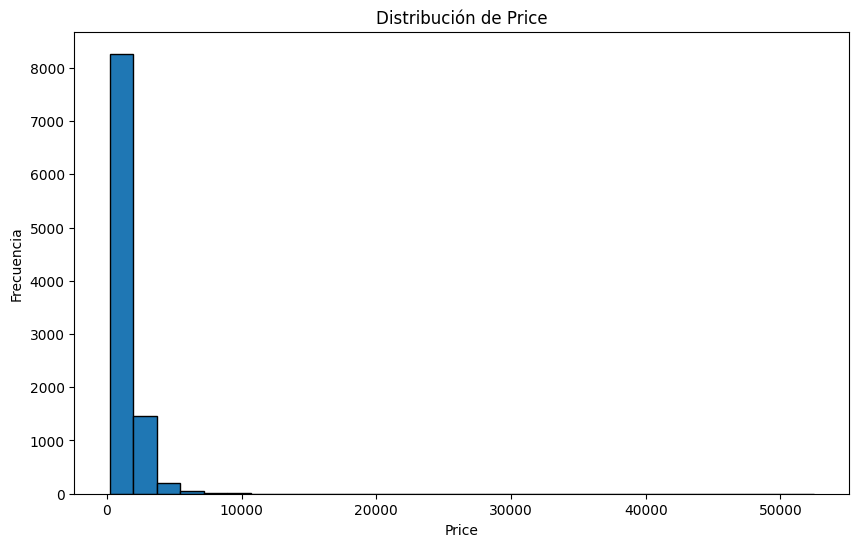

count     9999.000000
mean      1486.866687
std       1077.542535
min        200.000000
25%        949.000000
50%       1270.000000
75%       1695.000000
max      52500.000000
Name: price, dtype: float64

In [143]:
plt.figure(figsize=(10, 6))
plt.hist(data_filtered_6['price'], bins=30, edgecolor='k')
plt.title('Distribución de Price')
plt.xlabel('Price')
plt.ylabel('Frecuencia')
plt.show()
data_filtered_6['price'].describe()

In [157]:
# Definir una función para eliminar outliers usando el método del rango intercuartílico (IQR)
def eliminar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 5 * IQR
    return df[df[columna] <= upper_bound]

data_filtered_7 = eliminar_outliers(data_filtered_6, 'price')
data_filtered_7.shape

(9923, 16)

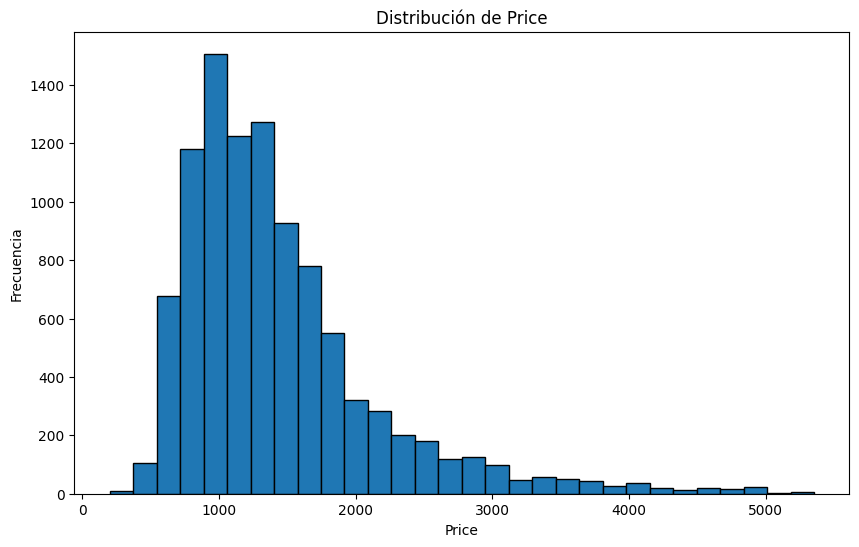

In [155]:
plt.figure(figsize=(10, 6))
plt.hist(data_filtered_7['price'], bins=30, edgecolor='k')
plt.title('Distribución de Price')
plt.xlabel('Price')
plt.ylabel('Frecuencia')
plt.show()